## Synthetic Experiments for AFLite.

Synthetic experiments for the paper [**Adversarial Filters of Dataset Biases**](https://arxiv.org/abs/2002.04108).

This notebook presents synthetic experiments to verify the capabilities of the AFLite algorithm, which removes instances exhibiting spurious biases from the dataset, thus enabling for accurate benchmark evaluation.

In [1]:
import numpy as np
import os
import pandas as pd

from matplotlib import pyplot as plt
from sklearn import svm, linear_model
from sklearn.datasets import make_circles

np.random.seed(0)

### Functions for plotting figures.

In [2]:
def plot_circles(data, plt):
    circles0 = data.loc[data.label==0]
    plt.scatter(circles0['x'], circles0['y'])
    circles1 = data.loc[data.label==1]
    plt.scatter(circles1['x'], circles1['y'])

def plot_artifacts(data, plt):
    circles0 = data.loc[data.label==0]
    plt.scatter(circles0['c1'], circles0['c2'])
    plt.show()
    circles1 = data.loc[data.label==1]
    plt.scatter(circles1['c1'], circles1['c2'])
    plt.show()

### Create or read circles data.

Binary classification data where the 2 dimensional data in each class is arranged in a circle, and the two classes are separated by different factors.

*Note*: If data is already created, we just load the data for reproducibility.

Reading data/circles/circles_sep_factor_0.4.csv
0.4 data size = 600
Reading data/circles/circles_sep_factor_0.6.csv
0.6 data size = 600
Reading data/circles/circles_sep_factor_0.7.csv
0.7 data size = 600
Reading data/circles/circles_sep_factor_0.8.csv
0.8 data size = 600


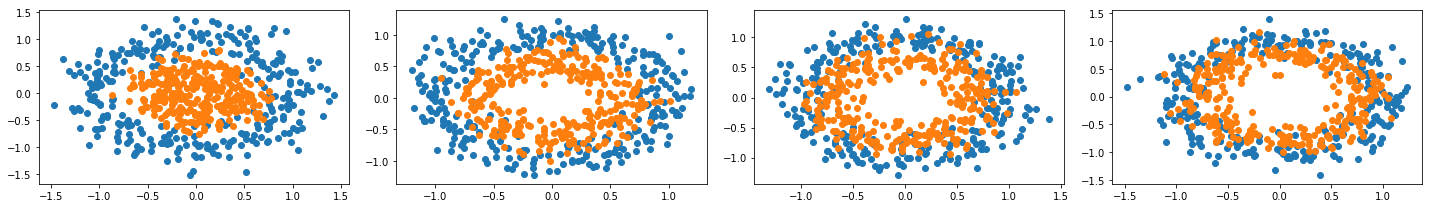

In [3]:
# Create circles with the following separation factors.
factors = [0.4, 0.6, 0.7, 0.8]  
circles = {factor:None for factor in factors}

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))
for i, factor in enumerate(factors):
    circles_file = f"data/circles/circles_sep_factor_{factor}.csv"
    if os.path.exists(circles_file):
        print(f"Reading {circles_file}")
        circles[factor] = pd.read_csv(circles_file)
    else:
        # Create circles
        print(f"Creating circles with separation factor {factor}")
        x, y = (make_circles(n_samples=600, 
                             shuffle=False, 
                             noise=0.2, 
                             random_state=None, 
                             factor=factor))
        df = pd.DataFrame(x)
        df['label'] = y
        df.rename(columns={0:"x", 1:"y"}, inplace=True)

        circles[factor] = df
        df.to_csv(circles_file, index_label=circles_file)
    
    print(f"{factor} data size = {len(circles[factor])}")
    plot_circles(circles[factor], axes[i])

fig.tight_layout()

### Functions to train and evaluate models on the data.

In [4]:
def accuracy(pred, ref):
    """Compute simple accuracy."""
    assert len(pred) == len(ref)
    correct = sum((pred == ref).astype('int'))
    return correct/len(ref)


def make_train_test_splits(data, feature_set):
    """Randomly split data into train (90%) and test (10%)."""
    n = len(data)
    test_ids = np.random.choice(range(n), n//10, replace=False)
    test = data.loc[test_ids]

    train_ids = np.array(list(set(range(n)).difference(set(test_ids))))
    train = data.loc[train_ids]
    
    train_data = train[feature_set]
    train_label = train['label']
    test_data = test[feature_set]
    test_label = test['label']
        
    return train_data, train_label, test_data, test_label


def train_rbf_simple(train_data, train_label, test_data, test_label):
    rbf = svm.SVC(gamma='auto',
                  # C=1.0,
                  # gamma=0.10,
                  tol=1e-5, 
                  random_state=np.random.randint(0, 100))   
    rbf.fit(train_data, train_label)
    rbf_predicted = rbf.predict(test_data)
    return accuracy(rbf_predicted, test_label.values)


def train_linear_simple(train_data, train_label, test_data, test_label):        
    lin = linear_model.SGDClassifier(max_iter=1000, 
                                     tol=1e-5)
    lin.fit(train_data, train_label)

    lin_predicted = lin.predict(test_data)
    return accuracy(lin_predicted, test_label.values)


def train_rbf_split(data, feats=['x', 'y', 'c1', 'c2'], num_seeds=1000):
    """
    Splits data into train and test, and then trains an SVM model with an
    RBF kernel on the train, and with the trained model, computes accuracy 
    on the test set. Repeats the above `num_seeds` times, and returns the 
    mean / std of accuracies on the test set (to reduce variance).
    """
    acc = []
    for _ in range(num_seeds):
        train_data, train_label, test_data, test_label = make_train_test_splits(data, feats)
        
        rbf = svm.SVC(gamma='auto', 
                      tol=1e-5, 
                      # C=1.0,
                      # gamma=0.10,
                      random_state=np.random.randint(0, 100))
        rbf.fit(train_data, train_label)
        
        rbf_predicted = rbf.predict(test_data)
        acc.append(accuracy(rbf_predicted, test_label.values))
    return f"RBF    acc: {np.mean(acc):.4f} (+/-{np.std(acc):.2f})"


def train_linear(data, feats=['x', 'y', 'c1', 'c2'], num_seeds=1000):
    """
    Splits data into train and test, and then trains a linear model on the 
    train, and with the trained model, computes accuracy 
    on the test set. Repeats the above `num_seeds` times, and returns the 
    mean / std of accuracies on the test set (to reduce variance).
    """
    acc = []
    for _ in range(num_seeds):
        train_data, train_label, test_data, test_label = make_train_test_splits(data, feats)
        
        lin = linear_model.SGDClassifier(max_iter=1000, 
                                         tol=1e-5)
        lin.fit(train_data, train_label)
        
        lin_predicted = lin.predict(test_data)
        acc.append(accuracy(lin_predicted, test_label.values))
    return f"LINEAR acc: {np.mean(acc):.4f} (+/-{np.std(acc):.2f})"

### Original Performance.
Train RBF and linear models on all four datasets, considering 2D features. With respect to a linear model, our data is not separable, whereas an RBF kernel is more successful. Moreover, the RBF kernel is more successful with data that is farther apart.

In [7]:
num_seeds = 1000
print(f"Original Performance with 2D features (Across {num_seeds} runs.):")

for i, factor in enumerate(factors):    
    print(f"\tsep: {factor} {train_linear(circles[factor], ['x', 'y'])}")
    print(f"\tsep: {factor} {train_rbf_split(circles[factor], ['x', 'y'])}")

Original Performance with 2D features (Across 1000 runs.)
	sep: 0.4 LINEAR acc: 0.5093 (+/-0.10)
	sep: 0.4 RBF    acc: 0.9483 (+/-0.03)
	sep: 0.6 LINEAR acc: 0.4965 (+/-0.07)
	sep: 0.6 RBF    acc: 0.8934 (+/-0.04)
	sep: 0.7 LINEAR acc: 0.4984 (+/-0.07)
	sep: 0.7 RBF    acc: 0.8188 (+/-0.05)
	sep: 0.8 LINEAR acc: 0.4955 (+/-0.07)
	sep: 0.8 RBF    acc: 0.7679 (+/-0.05)


***
## Introducing Artifacts

### Synthesizing artifact features.

We insert "bias/artifact" features to some of the data points --- the data points are selected randomly as below. There are two such features, each to be chosen from a different Gaussian. Each of the Gaussians is overwhelmingly associated with one class, and in few instances with the other.

In [8]:
# Assigning artifact data instances.
class_gauss = [[None, None], [None, None]]
if os.path.exists('data/cheat_keys/class0gauss0.csv'):
    print("Reading existing artifacted data IDs...")
    for i in range(2):
        for j in range(2):
            class_gauss[i][j] = pd.read_csv(f'data/cheat_keys/class{i}gauss{j}.csv')['idx'].values
else:
    print("Creating new artifacted data IDs...")
    artifacts_class0 = np.random.choice(range(300), 195, replace=False)
    class_gauss[0][1] = list(np.random.choice(artifacts_class0, 15, replace=False)) 
    class_gauss[0][0] = list(set(artifacts_class0).difference(set(class_gauss[0][1]))) # + class_gauss[0][1]
    assert len(set(class_gauss[0][0])) + len(class_gauss[0][1]) == 195
    
    artifacts_class1 = np.random.choice(range(300, 600), 195, replace=False)
    class_gauss[1][0] = list(np.random.choice(artifacts_class1, 15, replace=False)) 
    class_gauss[1][1] = list(set(artifacts_class1).difference(set(class_gauss[1][0]))) # + class_gauss[1][0]
    assert len(set(class_gauss[1][1])) + len(class_gauss[1][0]) == 195
    
    for i in range(2):
        for j in range(2):
            df = pd.DataFrame({'idx': class_gauss[i][j]})
            df.to_csv(f'data/cheat_keys/class{i}gauss{j}.csv')


Reading existing artifacted data IDs...


#### Synthesize Gaussian features for each artifact.

In [9]:
def introduce_gaussian_feature(probs, ntotal, mean, cl, covariance=0.1):
    assert len(probs) == nclasses

    n = ntotal//nclasses  # number of examples per class.
    features = np.random.rand(ntotal)
    for i, p in enumerate(probs):
        cheat_feats = np.random.normal(mean, covariance, int(p*n))
        assert len(cheat_feats) == len(class_gauss[i][cl])
        for cf, cind in zip(cheat_feats, class_gauss[i][cl]):
            features[cind] = cf
    assert len(features) == ntotal
    return np.expand_dims(features, axis=1)

art_circles = {factor:None for factor in factors}
for i, factor in enumerate(factors):
    artifacted_circles_file = f'data/circles/artifacted_circles_factor_{factor}.csv'

    if os.path.exists(artifacted_circles_file):
        print(f"Reading artifacted circles data from {artifacted_circles_file}.")
        art_circles[factor] = pd.read_csv(artifacted_circles_file)
    else:
        if factor == 0.9:
            circles_file = f"data/circles/flipped_circles_sep_factor_{factor}.csv"
        else:
            circles_file = f"data/circles/circles_sep_factor_{factor}.csv"
        
        print(f"Creating artifacts for circles data in {circles_file}.")
        art_circles[factor] = pd.read_csv(circles_file)

        nclasses = 2
        ntotal = len(art_circles[factor])

        cheat1 = introduce_gaussian_feature(probs=[0.6, 0.05], ntotal=ntotal, mean=-5, cl=0)
        cheat2 = introduce_gaussian_feature(probs=[0.05, 0.6], ntotal=ntotal, mean=5, cl=1)

        art_circles[factor]['c1'] = cheat1
        art_circles[factor]['c2'] = cheat2

        art_circles[factor].to_csv(artifacted_circles_file)
        print(f"Written to {artifacted_circles_file}")

Reading artifacted circles data from data/circles/artifacted_circles_factor_0.4.csv.
Reading artifacted circles data from data/circles/artifacted_circles_factor_0.6.csv.
Reading artifacted circles data from data/circles/artifacted_circles_factor_0.7.csv.
Reading artifacted circles data from data/circles/artifacted_circles_factor_0.8.csv.


In [11]:
print(f"Performance after introduction of artifacts (Across {num_seeds} runs.):")
linearb = {fac:None for fac in factors}
rbfb = {fac:None for fac in factors}

for i, factor in enumerate(factors):
    linearb[factor] = f"{train_linear(art_circles[factor])}"
    rbfb[factor] = f"{train_rbf_split(art_circles[factor])}"
    print(f"\tsep: {factor} {linearb[factor]}")
    print(f"\tsep: {factor} {rbfb[factor]}") 

Performance after introduction of artifacts (Across 1000 runs).
	sep: 0.4 LINEAR acc: 0.7527 (+/-0.10)
	sep: 0.4 RBF    acc: 0.9225 (+/-0.03)
	sep: 0.6 LINEAR acc: 0.7467 (+/-0.10)
	sep: 0.6 RBF    acc: 0.8987 (+/-0.04)
	sep: 0.7 LINEAR acc: 0.7474 (+/-0.09)
	sep: 0.7 RBF    acc: 0.8725 (+/-0.04)
	sep: 0.8 LINEAR acc: 0.7476 (+/-0.11)
	sep: 0.8 RBF    acc: 0.8419 (+/-0.04)


### Synthesize noise into data by flipping some of the data instances.
This is done for the most separable data, i.e. where separation `factor = 0.4`.

In [12]:
# Flip Index
def flip_index(data):
    cheat01filename = 'data/cheat_keys/flip_index_0_to_1.csv'
    if os.path.exists(cheat01filename):
        print("Reading indices to flip")
        cheat01 = pd.read_csv(cheat01filename)['idx'].values
    else:
        print("Creating flip indices")
        cheat01 = np.random.choice(class_gauss[0][1], 15, replace=False)
        pd.DataFrame({'idx': cheat01}).to_csv(cheat01filename)
    for j in cheat01:
        assert data.at[j,'label'] == 0
        data.at[j,'label'] = 1

    cheat10filename = 'data/cheat_keys/flip_index_1_to_0.csv'
    if os.path.exists(cheat10filename):
        print("Reading indices to flip")
        cheat10 = pd.read_csv(cheat10filename)['idx'].values
    else:
        print("Creating flip indices")
        cheat10 = np.random.choice(class_gauss[1][0], 15, replace=False)
        pd.DataFrame({'idx': cheat10}).to_csv(cheat10filename)
    for j in cheat10:
        assert data.at[j,'label'] == 1
        data.at[j, 'label'] = 0
    
    return data

In [13]:
first = art_circles[0.4].copy(deep=True)
flipped = flip_index(first)
# plot_circles(flipped, plt)
# plot_artifacts(flipped, plt)

Reading indices to flip
Reading indices to flip


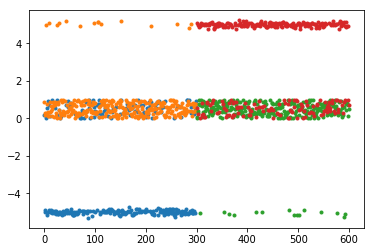

In [14]:
data = art_circles[0.4]
circles0 = data.loc[data.label==0]
plt.plot(circles0['c1'], '.')
plt.plot(circles0['c2'], '.')
# plt.scatter(circles0['c1'], circles0['c2'])
circles1 = data.loc[data.label==1]

plt.plot(circles1['c1'], '.')
plt.plot(circles1['c2'], '.')

# plt.scatter(circles1['c1'], circles1['c2'])
plt.show()

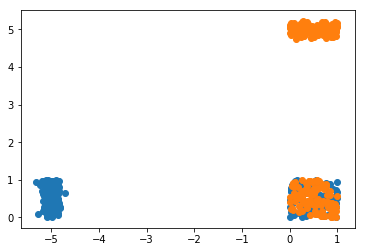

In [15]:
circles0 = flipped.loc[flipped.label==0]
# plt.plot(circles0['c1'], '.')
# plt.plot(circles0['c2'], '.')
plt.scatter(circles0['c1'], circles0['c2'])
circles1 = flipped.loc[flipped.label==1]

# plt.plot(circles1['c1'], '.')
# plt.plot(circles1['c2'], '.')

plt.scatter(circles1['c1'], circles1['c2'])
plt.show()

flipped.to_csv('data/circles/flipped_artifacted_circles_factor_0.4.csv', index_label="flipped")

In [16]:
print(f"Performance after flipping features (Across {num_seeds} runs.):")
linearb[0.4] = train_linear(flipped)
rbfb[0.4] = train_rbf_split(flipped)
for i, factor in enumerate(factors):
    print(f"\tsep: {factor} {linearb[factor]}")
    print(f"\tsep: {factor} {rbfb[factor]}") 

Performance after flipping features (Across 1000 runs.)
	sep: 0.4 LINEAR acc: 0.8322 (+/-0.05)
	sep: 0.4 RBF    acc: 0.9701 (+/-0.02)
	sep: 0.6 LINEAR acc: 0.7467 (+/-0.10)
	sep: 0.6 RBF    acc: 0.8987 (+/-0.04)
	sep: 0.7 LINEAR acc: 0.7474 (+/-0.09)
	sep: 0.7 RBF    acc: 0.8725 (+/-0.04)
	sep: 0.8 LINEAR acc: 0.7476 (+/-0.11)
	sep: 0.8 RBF    acc: 0.8419 (+/-0.04)


### Plotting final data.

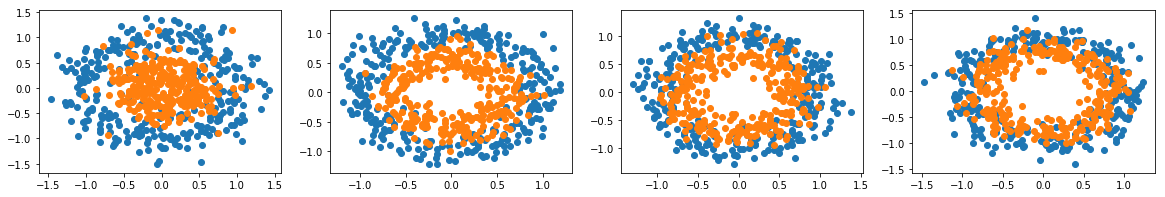

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))

for i, factor in enumerate(factors):
    if factor == 0.4:
        plot_circles(flipped, axes[i])
    else:
        plot_circles(art_circles[factor], axes[i])

***
## Run AFLite on data, and then return to notebook.
***

In [18]:
print(f"Performance after AFLite (Across {num_seeds} runs.):")
lineara = {fac:None for fac in factors}
rbfa = {fac:None for fac in factors}
        
for i, factor in enumerate(factors):
    aflit = pd.read_json(f"data/aflite_out_circles_sep_factor_{factor}/synthetic_filtered.jsonl", lines=True)
    filtered_ids = np.array(aflit['id'].values)

    x = art_circles[factor].loc[filtered_ids]
    acc_lin = []
    acc_rbf = []
    
    for _ in range(num_seeds):

        test_ids = np.random.choice(filtered_ids, 20, replace=False)
        ftest = art_circles[factor].loc[test_ids]
        train_ids = list(set(filtered_ids).difference(set(test_ids)))
        ftrain = art_circles[factor].loc[np.array(train_ids)]

        fxtrain = ftrain[['x','y', 'c1', 'c2']]
        fytrain = ftrain['label']

        fxtest = ftest[['x','y', 'c1', 'c2']]
        fytest = ftest['label']
    
        acc_lin.append(train_linear_simple(fxtrain, fytrain, fxtest, fytest))
        acc_rbf.append(train_rbf_simple(fxtrain, fytrain, fxtest, fytest))
        
    lineara[factor] = f"LINEAR acc: {np.mean(acc_lin):.4f} (+/-{np.std(acc_lin):.2f})"
    rbfa[factor] =    f"RBF    acc: {np.mean(acc_rbf):.4f} (+/-{np.std(acc_rbf):.2f})"
    print(f"\tsep: {factor} {lineara[factor]}")
    print(f"\tsep: {factor} {rbfa[factor]}")

Performance after AFLite (Across 1000 runs.)
	sep: 0.4 LINEAR acc: 0.5140 (+/-0.13)
	sep: 0.4 RBF    acc: 0.9056 (+/-0.06)
	sep: 0.6 LINEAR acc: 0.5216 (+/-0.12)
	sep: 0.6 RBF    acc: 0.8240 (+/-0.09)
	sep: 0.7 LINEAR acc: 0.5260 (+/-0.12)
	sep: 0.7 RBF    acc: 0.7743 (+/-0.09)
	sep: 0.8 LINEAR acc: 0.5321 (+/-0.12)
	sep: 0.8 RBF    acc: 0.7032 (+/-0.10)


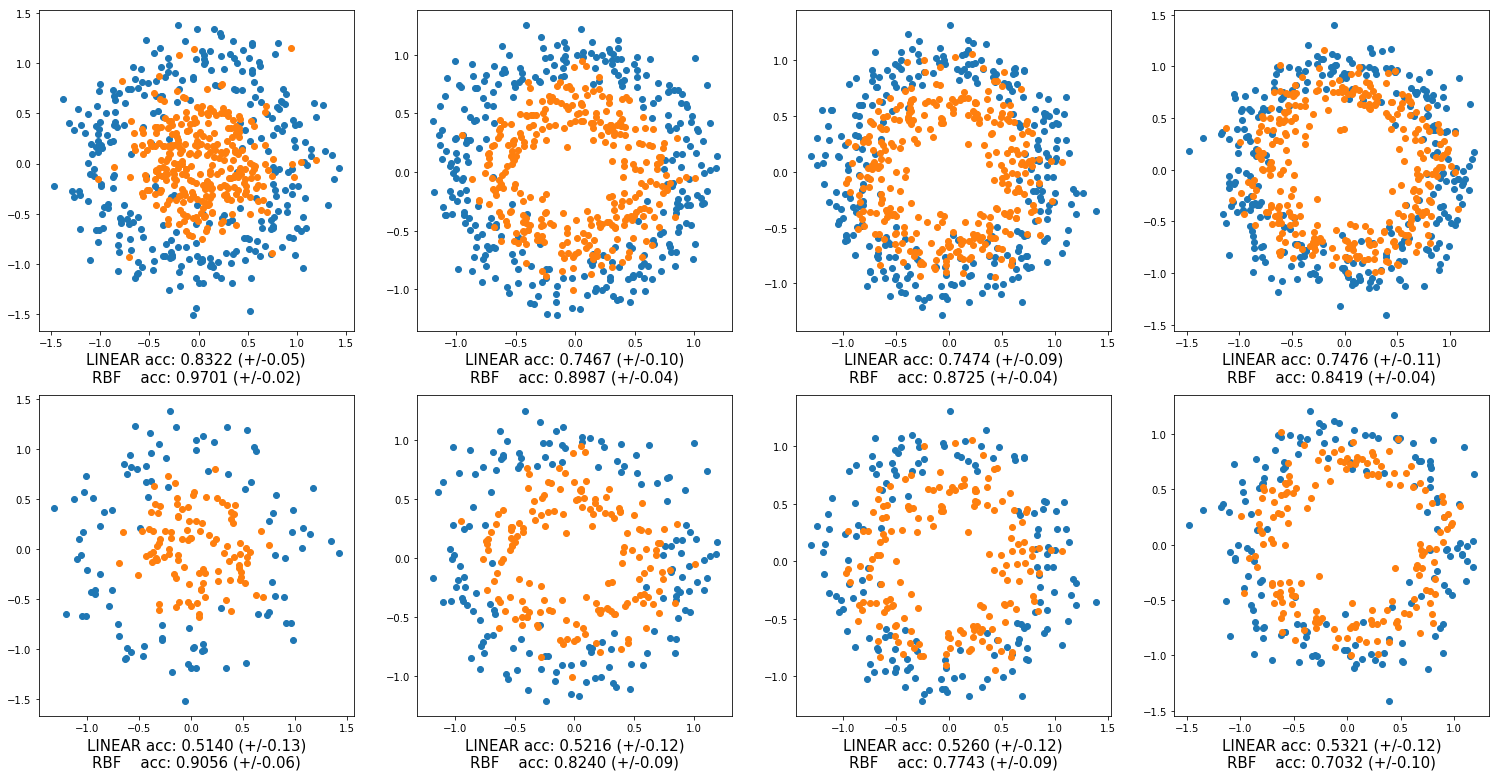

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(26, 13))
for i, factor in enumerate(factors):
    if factor == 0.4:
        plot_circles(flipped, axes[0][i])
    else:
        plot_circles(art_circles[factor], axes[0][i])
    axes[0][i].set(xlabel=f"{linearb[factor]}\n{rbfb[factor]}")
    axes[0][i].xaxis.label.set_fontsize(15)
                
for i, factor in enumerate(factors):
    aflit = pd.read_json(f"data/aflite_out_circles_sep_factor_{factor}/synthetic_filtered.jsonl", lines=True)
    filtered_ids = np.array(aflit['id'].values)

    x = art_circles[factor].loc[filtered_ids]
    plot_circles(x, axes[1][i])
        
    axes[1][i].set(xlabel=f"{lineara[factor]}\n{rbfa[factor]}")
    axes[1][i].xaxis.label.set_fontsize(15)


### Random Subset Evaluation

In [20]:
print(f"Performance on a random subset (Across {num_seeds} runs):")
for i, factor in enumerate(factors):
    art_c = art_circles[factor]
    random_circles_ids = np.random.choice(range(len(art_c)), len(filtered_ids), replace=False)
    random_circles = art_c.loc[np.array(random_circles_ids)]
    
    acc_lin = []
    acc_rbf = []
    for _ in range(num_seeds):

        rtest_ids = np.random.choice(random_circles_ids, len(ftest), replace=False)
        rtest = random_circles.loc[rtest_ids]
        rtrain_ids = list(set(random_circles_ids).difference(set(rtest_ids)))
        rtrain = random_circles.loc[np.array(rtrain_ids)]

        rxtrain = rtrain[['x','y', 'c1', 'c2']]
        rytrain = rtrain['label']

        rxtest = rtest[['x','y', 'c1', 'c2']]
        rytest = rtest['label']

        acc_lin.append(train_linear_simple(rxtrain, rytrain, rxtest, rytest))
        acc_rbf.append(train_rbf_simple(rxtrain, rytrain, rxtest, rytest))
        
    print(f"\tsep: {factor} LINEAR {np.mean(acc_lin):.4f} (+/-{np.std(acc_lin):.2f})")
    print(f"\tsep: {factor} RBF    {np.mean(acc_rbf):.4f} (+/-{np.std(acc_rbf):.2f})")


Performance on a random subset (Across 1000 runs):
	sep: 0.4 LINEAR 0.7179 (+/-0.14)
	sep: 0.4 RBF    0.9143 (+/-0.06)
	sep: 0.6 LINEAR 0.7608 (+/-0.13)
	sep: 0.6 RBF    0.8810 (+/-0.07)
	sep: 0.7 LINEAR 0.7469 (+/-0.13)
	sep: 0.7 RBF    0.8446 (+/-0.08)
	sep: 0.8 LINEAR 0.7578 (+/-0.13)
	sep: 0.8 RBF    0.8224 (+/-0.09)


### Fin.

If using in your research, please cite:

```
@inproceedings{bras2020adversarial,
    title={Adversarial Filters of Dataset Biases},
    author={Ronan Le Bras and Swabha Swayamdipta and Chandra Bhagavatula and Rowan Zellers and Matthew E. Peters and Ashish Sabharwal and Yejin Choi},
    year={2020},
    booktitle={Proc. of ICML},
    url={https://arxiv.org/abs/2002.04108},
}
```